In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置随机种子以保证实验的可重复性
torch.manual_seed(1234)

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义生成器模型
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# 定义判别器模型
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))




In [6]:
# 初始化生成器和判别器，并将它们移动到GPU上
input_dim = 100
output_dim = 784
generator = Generator(input_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

# 加载Fashion-MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义损失函数和优化器
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# 训练GAN模型
num_epochs = 20
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        batch_size = real_images.size(0)
        
        # 将真实图像移动到GPU上
        real_images = real_images.view(-1, 28*28).to(device)
        
        # 训练判别器
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # 真样本损失
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()
        
        # 生成假样本并计算损失
        noise = torch.randn(batch_size, input_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()
        
        d_optimizer.step()
        
        # 训练生成器
        g_optimizer.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {d_loss_real.item()+d_loss_fake.item():.4f}, Generator Loss: {g_loss.item():.4f}')

Epoch [1/20], Step [100/938], Discriminator Loss: 0.0871, Generator Loss: 3.4184
Epoch [1/20], Step [200/938], Discriminator Loss: 0.0459, Generator Loss: 4.1433
Epoch [1/20], Step [300/938], Discriminator Loss: 0.0244, Generator Loss: 4.5201
Epoch [1/20], Step [400/938], Discriminator Loss: 0.0239, Generator Loss: 4.8212
Epoch [1/20], Step [500/938], Discriminator Loss: 0.0106, Generator Loss: 5.0319
Epoch [1/20], Step [600/938], Discriminator Loss: 0.0089, Generator Loss: 5.1903
Epoch [1/20], Step [700/938], Discriminator Loss: 0.0061, Generator Loss: 5.4011
Epoch [1/20], Step [800/938], Discriminator Loss: 0.0338, Generator Loss: 5.6036
Epoch [1/20], Step [900/938], Discriminator Loss: 0.0048, Generator Loss: 5.6397
Epoch [2/20], Step [100/938], Discriminator Loss: 0.0049, Generator Loss: 5.8163
Epoch [2/20], Step [200/938], Discriminator Loss: 0.0109, Generator Loss: 5.9775
Epoch [2/20], Step [300/938], Discriminator Loss: 0.0481, Generator Loss: 5.9854
Epoch [2/20], Step [400/938]

In [7]:
# 保存生成器和判别器模型
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Models saved.")

Models saved.


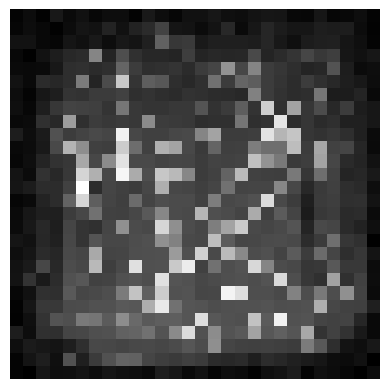

In [22]:
# 加载生成器模型并生成图片
generator = Generator(input_dim, output_dim).to(device)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

noise = torch.randn(1, input_dim).to(device)
fake_image = generator(noise)
fake_image = fake_image.view(28, 28).detach().cpu().numpy()

# 显示生成的图片
plt.imshow(fake_image, cmap='gray')
plt.axis('off')
plt.show()